In [22]:
#Import the libraries
import os, random
import numpy as np
import pandas as pd
import tensorflow as tf
import librosa as lib
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import wavfile as wav
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import accuracy_score

from tensorflow.keras.layers import Dense,Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential
import IPython.display as ipd
%matplotlib inline

In [53]:
#Access the audio image filepath
train_audio_path = '../Dataset audio samples/classification dataset/'
test_audio_path = '../Dataset audio samples/classification test samples/'
labels = os.listdir(train_audio_path)
print(labels)

['left', 'one', 'right', 'stop', 'three', 'two']


In [3]:
#Audio signal EDA and visualization
test_sample, test_rate = lib.load(train_audio_path+'right/0ea0e2f4_nohash_0.wav', sr=8000)

print(test_sample.shape)
print(test_rate)
print(len(test_sample))
print(len(test_sample)/test_rate)

(8000,)
8000
8000
1.0


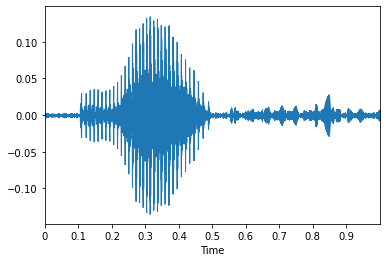

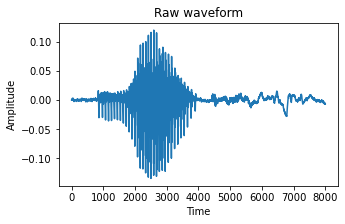

In [4]:
#Plotting the time-series amplitude-time waveform
librosa.display.waveplot(test_sample, test_rate)

#Plotting using matplotlib
plt.figure(figsize=(5,3))
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Raw waveform')
plt.plot(test_sample)

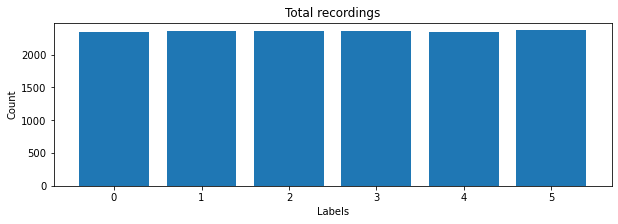

In [5]:
#No. of recordings in each label
sample_count=[]

for label in labels:
    sample_count.append(len([f for f in os.listdir(train_audio_path+label) if f.endswith('.wav')]))

#Plotting using matplotlib
plt.figure(figsize=(10,3))
index = np.arange(len(labels))
plt.bar(index, sample_count)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Total recordings')
plt.show(sample_count)

C:\Users\Mehak\anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Mehak\anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


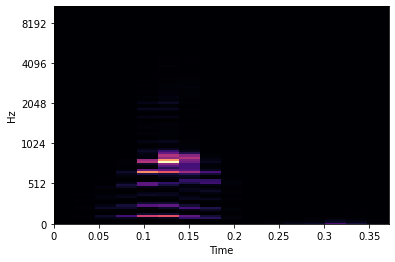

In [9]:
#Display spectogram
ipd.Audio(train_audio_path+'right/0ea0e2f4_nohash_0.wav')
spec = lib.feature.melspectrogram(test_sample,test_rate)
lib.display.specshow(spec, y_axis='mel', x_axis='time')

Scipy: sample, rate, bit-depth(min, max):  [  -9   -4   -8 ... -209 -197 -183] 16000 -4410 3930
Librosa: sample, rate, bit-depth(min, max):  [-0.00026596 -0.00018007 -0.000125   ... -0.00602599 -0.00643429
 -0.00410269] 22050 -0.13435018 0.12273543


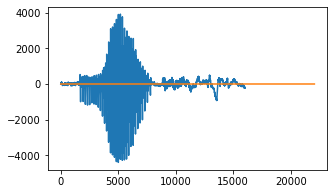

In [10]:
#Audio signal preprocessing
# 1. Resampling
# 2. Signal duration filtering (<1s)
# 3. Bit rate depth normalization
# 4. Stereo to mono channel
#
# Librosa libarary handles resampling (22.5kHz, sterso to mono channel, bit-depth normalization)
audio_file = train_audio_path+'right/0ea0e2f4_nohash_0.wav'
scipy_rate, scipy_audio= wav.read(audio_file,)
lib_audio, lib_rate = lib.load(audio_file)


print('Scipy: sample, rate, bit-depth(min, max): ', scipy_audio, scipy_rate, np.min(scipy_audio), np.max(scipy_audio))
print('Librosa: sample, rate, bit-depth(min, max): ', lib_audio, lib_rate, np.min(lib_audio), np.max(lib_audio))

plt.figure(figsize=(5,3))
plt.plot(scipy_audio)
plt.plot(lib_audio)

In [11]:
#Preprocessing below:
#Resampling at 8000kHz
#Filtering out audio <1s in length
#Creating arrays of audio and its labels an dcreate a dataframe from them

x_audio_array=[]
y_label_array=[]
sample_rate = 8000
count = 0
count1 = 0

for label in labels:
    audios = [f for f in os.listdir(train_audio_path+label) if f.endswith('.wav')]
    for aud in audios:
        count+=1
        #Resampling
        sam,rate = lib.load(train_audio_path+label+'/'+aud, sr=sample_rate)
        if len(sam)/rate == 1:
            count1+=1
            #Feature extraction using MFCC
            mfcc = lib.feature.mfcc(sam, sr = sample_rate, n_mfcc=40)
            x_audio_array.append(mfcc)
            y_label_array.append(label)

In [12]:
#Create pandas dataframe
x_audio_array = np.array(x_audio_array)
y_label_array = np.array(y_label_array)
df=pd.DataFrame(list(zip(np.array(x_audio_array), y_label_array)), columns =['Audio', 'Label'])
df.head()

#Shuffle the dataset
df = df.sample(frac=1)

#Create X and Y numpy arrays for model training
#x_audios = np.array(df.Audio.tolist())
#y_labels = np.array(df.Label.tolist())

In [13]:
df.head()
print(x_audio_array.shape)
print(y_label_array.shape)

(12837, 40, 16)
(12837,)


In [14]:
#Encoding categorical data(labels)
lb = LabelBinarizer()
y_encoded = lb.fit_transform(y_label_array)
print(y_encoded.shape)

(12837, 6)


In [15]:
x_audios = np.array(x_audio_array).reshape(x_audio_array.shape[0], 40, 16, 1)
print(x_audios.shape)

(12837, 40, 16, 1)


In [16]:
#Split datasets into training and test data
x_train, x_test, y_train, y_test = train_test_split(x_audios, y_encoded, test_size=0.3, random_state=0)

print(x_train.shape)

(8985, 40, 16, 1)


In [17]:
#Create 1D conv1d CNN model

#Initializing the CNN
cnn2d = Sequential()

#Add 1st convolutional layer
cnn2d.add(Conv2D(filters=32, kernel_size=2, activation='relu', input_shape=[40,16,1]))
#Add 1st max pooling layer
cnn2d.add(MaxPooling2D(pool_size=2, strides=2))

#Add 2nd convolutional and pooling layer for deep CNN
cnn2d.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
cnn2d.add(MaxPooling2D(pool_size=2, strides=2))

#Add 3rd convolutional and pooling layer for deep CNN
cnn2d.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
cnn2d.add(MaxPooling2D(pool_size=2, strides=2))

#Flattening
cnn2d.add(Flatten())

#Add fully connected layer (ANN)
cnn2d.add(Dense(units=128, activation='relu'))
cnn2d.add(Dropout(0.3))

#Add output layer
cnn2d.add(Dense(units=6, activation='softmax'))

cnn2d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 15, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 7, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 6, 32)         4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 2, 32)          4128      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 1, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

In [18]:
#Compile CNN
cnn2d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Fit the model(train)
cnn2d.fit(x_train, y_train, batch_size=32, epochs=150)

Epoch 1/150
281/281 [==============================] - 7s 25ms/step - loss: 1.2800 - accuracy: 0.5196
Epoch 2/150
281/281 [==============================] - 7s 23ms/step - loss: 0.5571 - accuracy: 0.8027
Epoch 3/150
281/281 [==============================] - 7s 25ms/step - loss: 0.4037 - accuracy: 0.8535
Epoch 4/150
281/281 [==============================] - 7s 23ms/step - loss: 0.3352 - accuracy: 0.8763
Epoch 5/150
281/281 [==============================] - 6s 23ms/step - loss: 0.2944 - accuracy: 0.8963
Epoch 6/150
281/281 [==============================] - 6s 23ms/step - loss: 0.2622 - accuracy: 0.9092
Epoch 7/150
281/281 [==============================] - 6s 23ms/step - loss: 0.2330 - accuracy: 0.9182
Epoch 8/150
281/281 [==============================] - 7s 23ms/step - loss: 0.2135 - accuracy: 0.9255 1s - loss: 0.2116 - accuracy
Epoch 9/150
281/281 [==============================] - 7s 24ms/step - loss: 0.1971 - accuracy: 0.9288
Epoch 10/150
281/281 [==============================]

281/281 [==============================] - 7s 24ms/step - loss: 0.0314 - accuracy: 0.9907
Epoch 80/150
281/281 [==============================] - 7s 24ms/step - loss: 0.0237 - accuracy: 0.9929 0s - loss: 0.0239 - accuracy: 0.
Epoch 81/150
281/281 [==============================] - 7s 24ms/step - loss: 0.0524 - accuracy: 0.9845
Epoch 82/150
281/281 [==============================] - 7s 24ms/step - loss: 0.0521 - accuracy: 0.9862
Epoch 83/150
281/281 [==============================] - 7s 24ms/step - loss: 0.0261 - accuracy: 0.9920
Epoch 84/150
281/281 [==============================] - 7s 24ms/step - loss: 0.0213 - accuracy: 0.9939
Epoch 85/150
281/281 [==============================] - 7s 24ms/step - loss: 0.0331 - accuracy: 0.9904
Epoch 86/150
281/281 [==============================] - 7s 24ms/step - loss: 0.0251 - accuracy: 0.9933
Epoch 87/150
281/281 [==============================] - 7s 24ms/step - loss: 0.0308 - accuracy: 0.9911
Epoch 88/150
281/281 [==============================]

In [106]:
# Evaluating the model on the training and testing set
score = cnn2d.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = cnn2d.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9983305335044861
Testing Accuracy:  0.9208203554153442


In [107]:
#Predict using ann model
res=cnn2d.predict(x_test)
print(lb.inverse_transform((res[0].reshape(1,-1)))[0])
print('Accuracy score: ', accuracy_score(lb.inverse_transform(y_test),lb.inverse_transform(res)))

stop
Accuracy score:  0.9208203530633438


In [108]:
def predict_audio(filename):
    filepath = test_audio_path + filename
    audio, sam = lib.load(filepath, sr=8000)
    mfcc = lib.feature.mfcc(audio, sr = sample_rate, n_mfcc = 40)
    pad_width = 16 - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)))
    
    audio_predicted=cnn2d.predict(mfcc.reshape(1,40,16,1))
    audio_class = lb.inverse_transform(audio_predicted) 
    print('Your audio (' + filename + ') belongs to the label: ', audio_class[0].upper())

In [109]:
import sounddevice as sd
from scipy.io.wavfile import write

def record_audio():
    rate = 8000  # Sample rate
    seconds = 1  # Duration of recording

    my_audio = sd.rec(int(seconds * rate), samplerate=rate, channels=1)
    sd.wait()  # Wait until recording is finished
    write(test_audio_path + 'test.wav', rate, my_audio)  # Save as WAV file 
    return 'test.wav'

In [117]:
#Classify a random audio file from the unlabeled test folder
file = random.choice([f for f in os.listdir(test_audio_path)])
predict_audio(file)
ipd.Audio(test_audio_path+file, autoplay=True)

Your audio (left (5).wav) belongs to the label:  LEFT


In [120]:
#Classify a live spoken audio through microphone
predict_audio(record_audio())
ipd.Audio(test_audio_path+'test.wav', autoplay=True)

Your audio (test.wav) belongs to the label:  STOP
